In [1]:
import scipy.stats as stats
import scikit_posthocs as sp
from IPython.display import Markdown
import cv2
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

models = ['ridge_cox', 'elastic_net_cox', 'random_survival_forest', 'gradient_boosting']

file_names_map = {
    'ridge_cox': 'model=(ridge_cox)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'elastic_net_cox': 'model=(elastic_net_cox)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'random_survival_forest': 'model=(random_survival_forest)_general_pp=(ohe_norm)_cf_pp=(bool)', 
    'gradient_boosting': 'model=(gradient_boosting)_general_pp=(ohe_norm)_cf_pp=(bool)'
}

names_map = {
    'ridge_cox': "Ridge-Cox's\nPH", 
    'elastic_net_cox': "Elastic Net-Cox's\nPH", 
    'random_survival_forest': "Random Survival\nForest", 
    'gradient_boosting': "Gradient Boosting\nSurvival Analysis"
}

names_map_2 = {
    'ridge_cox': "Ridge-Cox's PH", 
    'elastic_net_cox': "Elastic Net-Cox's PH", 
    'random_survival_forest': "Random Survival Forest", 
    'gradient_boosting': "Gradient Boosting Survival Analysis"
}

names_map_3 = {
    'ridge_cox': "RC", 
    'elastic_net_cox': "ENC", 
    'random_survival_forest': "RSF", 
    'gradient_boosting': "GBSA"
}

metric_names = {
    'cindex': 'C-index', 
    'mean_auc': 'Mean time-dependent AUC', 
    'brier': 'Brier score'
}


In [2]:
def StatisticalTests(models, metric, alpha=0.05): 
    
    aux_models = []
    data = []
    for model in models: 
        scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
        if len(scores[metric]) != 0:
            if metric == 'brier': 
                data.append([-s for s in scores[metric]])
            else: 
                data.append(scores[metric])
            aux_models.append(model)
            
            
    models = aux_models
    data = np.array(data)
        
    print("\n############")    
    print("ANOVA TEST")
    print("############\n")  
    fvalue, pvalue = stats.f_oneway(*data)
    print("F-value: " , fvalue)
    print("p-value: ", pvalue)
    print("different: YES" if pvalue<alpha else "different: NO")
    
    print("\n############") 
    print("FRIEDMAN TEST")
    print("############\n")
    statistic, pvalue = stats.friedmanchisquare(*data)
    print("statistic " , statistic)
    print("p-value: ", pvalue)
    print("different: YES" if pvalue<alpha else "different: NO")
    
    print("\n############")
    print("t STUDENT TEST")
    print("############\n") 
    print('different:')
    
    heatmap_bool = []
    heatmap_pvalues = []
    for i, model1 in enumerate(models): 
        row_bool = []
        row_pvalues = []
        for j, model2 in enumerate(models): 
            if model1 == model2: 
                row_bool.append(False)
                row_pvalues.append('')
            else: 
                t_satistic, pvalues= stats.ttest_rel(data[i], data[j])
                row_bool.append(pvalue<alpha)
                row_pvalues.append('{:.2e}'.format(pvalues))
        heatmap_bool.append(row_bool)
        heatmap_pvalues.append(row_pvalues)
    
    plt.figure(figsize=(4,4))
    im = plt.imshow(heatmap_bool, cmap=plt.get_cmap('Set3', 2))
    for i in range(len(heatmap_pvalues)): 
        for j in range(len(heatmap_pvalues[i])): 
            text = plt.text(j, i, heatmap_pvalues[j][i], ha='center', va='center', fontsize=8)
    plt.xticks(range(len(models)), labels=[names_map[model] for model in models], rotation=30, ha='right')
    plt.yticks(range(len(models)), labels=[names_map[model] for model in models])
    cbar = plt.colorbar(im, shrink=0.3, ticks=[False, True])
    cbar.ax.set_yticklabels(['NO', 'YES'])
    plt.show()


    print("\n############")
    print("NEMENYI TEST")
    print("############\n") 
    
    pvalues = sp.posthoc_nemenyi_friedman(data.T)
    different= pvalues < alpha
    
    plt.figure(figsize=(4,4))
    im = plt.imshow(different, cmap=plt.get_cmap('Set3', 2))
    for i in range(len(pvalues)): 
        for j in range(len(pvalues[i])): 
            if i!=j: 
                text = plt.text(j, i, '{:.2e}'.format(pvalues[j][i]), ha='center', va='center', fontsize=8)
            
    plt.xticks(range(len(models)), labels=[names_map[model] for model in models], rotation=30, ha='right')
    plt.yticks(range(len(models)), labels=[names_map[model] for model in models])
    cbar = plt.colorbar(im, shrink=0.3, ticks=[False, True])
    cbar.ax.set_yticklabels(['NO', 'YES'])
    plt.show()


############
ANOVA TEST
############

F-value:  26.011483488173216
p-value:  1.110947441516452e-11
different: YES

############
FRIEDMAN TEST
############

statistic  41.65326633165829
p-value:  4.752774879990149e-09
different: YES

############
t STUDENT TEST
############

different:


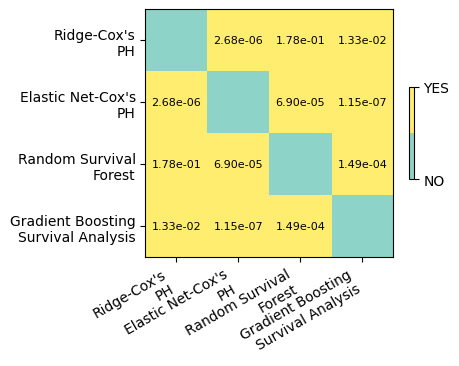


############
NEMENYI TEST
############



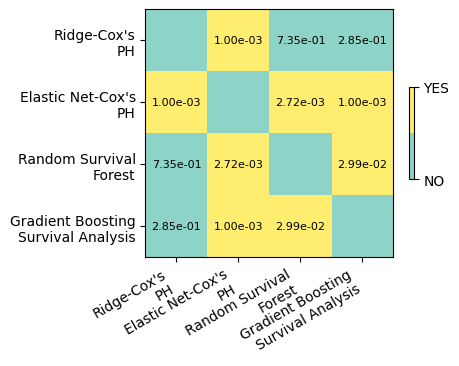

In [3]:
StatisticalTests(models, 'cindex')


############
ANOVA TEST
############

F-value:  22.770077579830158
p-value:  1.2819899627546986e-10
different: YES

############
FRIEDMAN TEST
############

statistic  40.079999999999984
p-value:  1.0247053802133793e-08
different: YES

############
t STUDENT TEST
############

different:


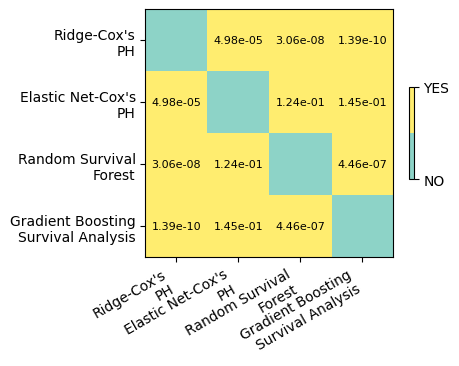


############
NEMENYI TEST
############



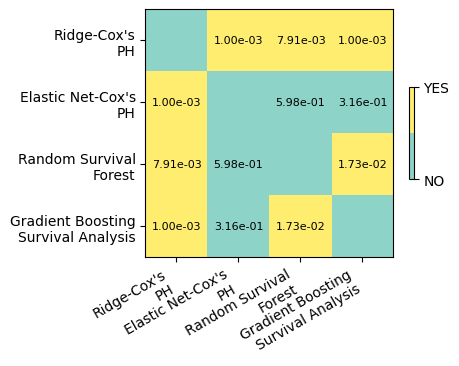

In [4]:
StatisticalTests(models, 'brier')


############
ANOVA TEST
############

F-value:  21.91476275462116
p-value:  2.510601478370317e-10
different: YES

############
FRIEDMAN TEST
############

statistic  38.51999999999998
p-value:  2.193494408492656e-08
different: YES

############
t STUDENT TEST
############

different:


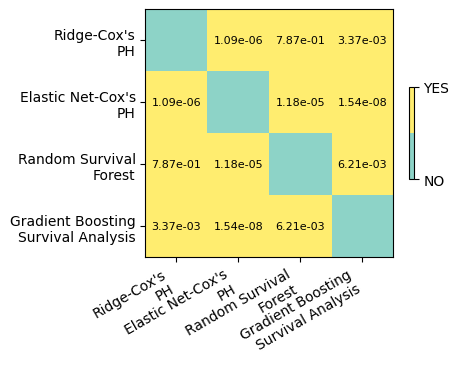


############
NEMENYI TEST
############



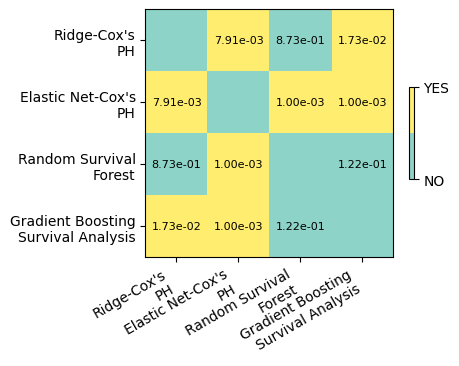

In [5]:
StatisticalTests(models, 'mean_auc')

In [6]:
from matplotlib import colors
from autorank import autorank, create_report, latex_table, plot_stats

def generateNemenyiPlot(models, metrics, alpha=0.05): 
    
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), sharey=True,gridspec_kw={'wspace': 0.05})
    for n_metric, metric in enumerate(metrics): 
    
        aux_models = []
        data = []
        for model in models: 
            scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
            if len(scores[metric]) != 0:
                if metric == 'brier': 
                    data.append([-s for s in scores[metric]])
                else: 
                    data.append(scores[metric])
                aux_models.append(model)


        models = aux_models
        data = np.array(data)

        #Nemenyi scipy
        pvalues = sp.posthoc_nemenyi_friedman(data.T)
        different= pvalues < alpha
        
        divnorm = colors.TwoSlopeNorm(vmin=-0.45, vcenter=0.05, vmax=0.55)
        im = axs[n_metric].imshow(pvalues, cmap=plt.get_cmap('coolwarm'), norm=divnorm, aspect='auto')
        for i in range(len(pvalues)): 
            for j in range(len(pvalues[i])): 
                if i!=j: 
                    text = axs[n_metric].text(j, i, '{:.4}'.format(round(pvalues[j][i], 4)), ha='center', va='center', fontsize=9)

        axs[n_metric].set_xticks(range(len(models)), labels=[names_map[model] for model in models], rotation=30, ha='right', fontsize=10)
        axs[n_metric].set_yticks(range(len(models)), labels=[names_map[model] for model in models], rotation=30, fontsize=10)
        axs[n_metric].set_title(metric_names[metric], fontsize=10)

    cbar = plt.colorbar(im, ax=axs[:], shrink=0.3, ticks=[0.049, 0.05, 0.051], orientation='horizontal', pad=0.35)
    cbar.ax.set_xticklabels(['Statistical difference\t\t\t\t\t\t\t\t\t\t'.replace('\t', '      '), 
                             r'$\alpha$=0.05', 
                             '\t\t\t\t\t\t\t\t\t\tNo statistical difference'.replace('\t', '      ')], 
                            fontsize=10)
    fig.savefig(f'figs/nemenyi.pdf', bbox_inches='tight', format='pdf')

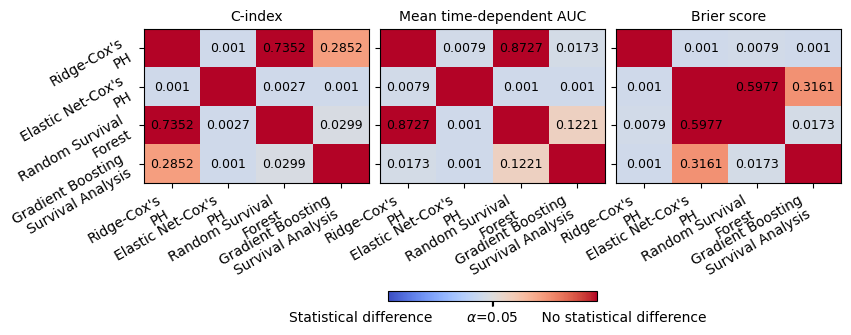

In [7]:
generateNemenyiPlot(models, ['cindex', 'mean_auc','brier'])

In [8]:
from matplotlib import colors
from autorank import autorank, create_report, latex_table, plot_stats
import cv2

def generateNemenyiPlot2(models, metrics, alpha=0.05): 
    
    for n_metric, metric in enumerate(metrics): 
    
        aux_models = []
        data = []
        for model in models: 
            scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
            if len(scores[metric]) != 0:
                if metric == 'brier': 
                    data.append([-s for s in scores[metric]])
                else: 
                    data.append(scores[metric])
                aux_models.append(model)


        models = aux_models
        data = np.array(data)
        
        #Nemenyi autorank
        df_data = pd.DataFrame(columns=[names_map_3[model] for model in models], data=data.T)
        res = autorank(df_data, alpha=0.05, verbose=False, force_mode='nonparametric')
        plot_stats(res, width=3)
        plt.title(metric_names[metric], fontsize=10)
        plt.margins(-0.49)
        plt.savefig(f"figs/critical_diff_{metric}.png", bbox_inches='tight')
    
    imgs = []
    for n_metric, metric in enumerate(metrics):   

        img_aux = cv2.imread(f'figs/critical_diff_{metric}.png') 
        img_aux = img_aux[5:180, 30:270, :] #remove big margins 
        imgs.append(img_aux)
        print(img_aux.shape)
        
    img_final = cv2.hconcat(imgs) 
    cv2.imwrite('figs/critical_diff.png', img_final)

In [10]:
from PyPDF2 import PdfReader, PdfWriter, PdfMerger, PageObject, Transformation
from PyPDF2.generic import RectangleObject

def pdf_crop(pdf_path, upper=0, lower=0, left=0, right=0, output_file_name=None): 

    if upper<0 or upper>1 or lower<0 or lower>1 or left<0 or left>1 or right<0 or right>1: 
        raise Exception('lower, upper, left and right must be numerical values between 0 and 1.')
    
    #read pdf page
    reader = PdfReader(open(pdf_path, 'rb'))
    page = reader.pages[0]
    
    #calculate new margins 
    _, y = page.cropbox.upper_left
    x,_ = page.cropbox.lower_right
    upper = upper*float(page.mediabox.height)
    lower = lower*float(page.mediabox.height)
    left = left*float(page.mediabox.width)
    right = right*float(page.mediabox.width)
    
    #apply new margins 
    page.add_transformation(Transformation().translate(-left, -lower))
    new_mediabox = RectangleObject((0, 0, float(page.mediabox.width)-right-left, float(page.mediabox.height)-upper-lower))
    new_trimbox = RectangleObject((0, 0, float(page.mediabox.width)-right-left, float(page.mediabox.height)-upper-lower))
    page.mediabox = new_mediabox
    page.trimbox = new_trimbox
    new_upper_left = (0, float(y)-upper-lower)
    new_lower_right = (float(x)-right-left, 0)
    page.cropbox.upper_left = new_upper_left
    page.cropbox.lower_right = new_lower_right

    #save new pdf
    writer = PdfWriter()
    writer.add_page(page)
    if output_file_name: 
        file_name = output_file_name
    else: 
        file_name = pdf_path
    with open(file_name, 'wb') as f:
        writer.write(f)
    

def pdf_combine(pdf_list, orientation='horizontal', output_file_name='merge.pdf'):
    
    pages = []
    final_width = 0
    final_height = 0
    
    for pdf in pdf_list:
        reader = PdfReader(open(pdf, 'rb'))
        page = reader.pages[0]
        pages.append(page)
        if orientation == 'horizontal': 
            final_width+= float(page.mediabox.width)
            final_height = page.mediabox.height
        else: 
            final_width = page.mediabox.width
            final_height+= float(page.mediabox.height)
        
    final_page = PageObject.create_blank_page(None, final_width, final_height)
    
    for i_page in range(len(pages)-1, -1, -1): #pages in reverse order
        
        final_page.merge_page(pages[i_page])

        if i_page != 0: 
            if orientation == 'horizontal': 
                tx = float(pages[i_page-1].mediabox.width)
                ty = 0
            else: 
                tx = 0
                ty = float(pages[i_page-1].mediabox.height)
            final_page.add_transformation(Transformation().translate(tx, ty))
    
    writer = PdfWriter()
    writer.add_page(final_page)
    with open(output_file_name, 'wb') as f:
        writer.write(f)

In [11]:
def generateNemenyiPlot2(models, metrics, alpha=0.05): 
    
    for n_metric, metric in enumerate(metrics): 
    
        aux_models = []
        data = []
        for model in models: 
            scores = pk.load(open(f'results/scores_{file_names_map[model]}.pk', 'rb'))
            if len(scores[metric]) != 0:
                if metric == 'brier': 
                    data.append([-s for s in scores[metric]])
                else: 
                    data.append(scores[metric])
                aux_models.append(model)


        models = aux_models
        data = np.array(data)
        
        #Nemenyi autorank
        df_data = pd.DataFrame(columns=[names_map_3[model] for model in models], data=data.T)
        res = autorank(df_data, alpha=0.05, verbose=False, force_mode='nonparametric')
        plot_stats(res, width=3)
        plt.title(metric_names[metric], fontsize=10)
        plt.margins(-0.49)
        plt.savefig(f"figs/critical_diff_{metric}.pdf", bbox_inches='tight')
    
    for metric in metrics: 
        pdf = f'figs/critical_diff_{metric}.pdf'
        pdf_crop(pdf, left=0.13, right=0.13, lower=0.14)
    pdfs = [f'figs/critical_diff_{metric}.pdf' for metric in metrics]
    pdf_combine(pdfs, orientation='horizontal', output_file_name='figs/critical_diff.pdf')

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


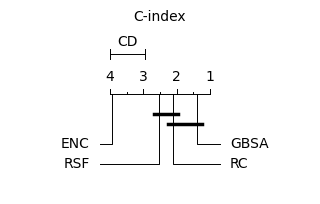

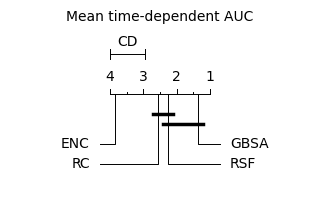

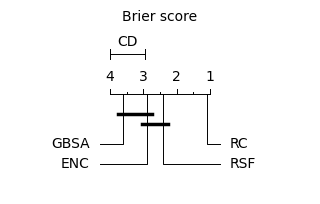

In [12]:
generateNemenyiPlot2(models, ['cindex', 'mean_auc','brier'])